In [2]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas as pd
import numpy as np

import itertools

In [3]:
def generate_plot(src_path='x_test_sample.csv', img_path='sample1.png'):
    data = pd.read_csv(src_path)
    display(data.head())
    plt.figure(figsize=(16,4), dpi=200)
    sns.lineplot(x=np.linspace(0,data.shape[1],data.shape[1]), y=data.iloc[0,:])
    plt.ylim([0,1])
    plt.savefig(img_path, dpi=200)
    plt.show()
    return

# Readme
`Goal` : Build a neural network that can accurately estimate parameters of a sine function, even when noise is added. Input data is synthetic - created to pretrain the network on noisy sine waves that approximate the behavior of real world sinusoidal activity as measured in the height of the ionosphere.

### Example Training Data
![SampleTrainingData](sample1.png)


# Variations in Synthetic Data
- **Sine Wave**:  
    - `period` : period of each sign wave, target variable  
    - `amplitude` : amplitude associated with the sine wave  
    - `phase` : where the sine wave starts horizontally  
- **Noise**:
    - `noise distribution` : generating distribution for the noise added to the wave
    - `noise magnitude` : magnitude of noise added to the sine wave
    - `noise method` : multiplicative or additive noise
- **Additional**:
    - `padding` : how values are padded, primarily concerning if sine waves are repeated for multiple periods or only a single period with padding values

## Constants

In [4]:
SINE_LEN = 251
N_EPOCHS = 200
NOISE_SAMPLES = 12

## Sine Wave Generation

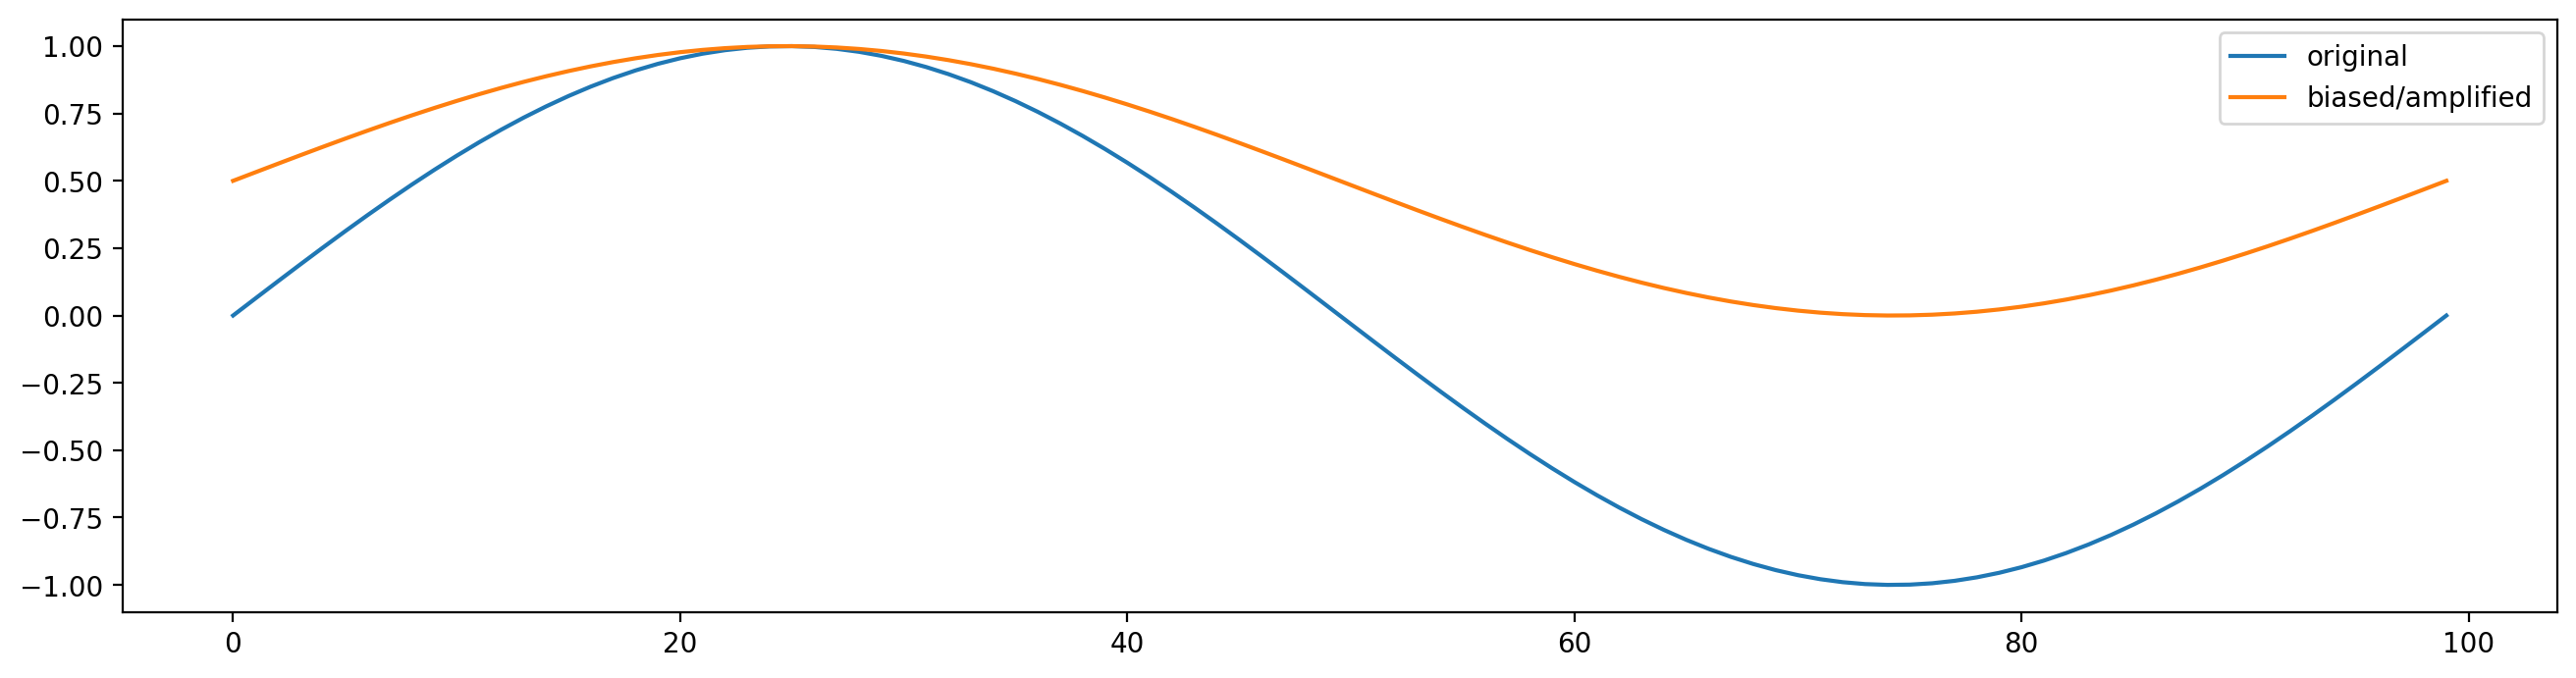

In [17]:
def base_wave(n_periods=1, phase_angle=0, arr_len=100):
    assert isinstance(arr_len, int) and arr_len > 0, f'{arr_len} not a valid integer size'
    x_radians = np.linspace(phase_angle,n_periods*np.pi*2+phase_angle,arr_len)
    return np.sin(x_radians)

def bias_amplitude(arr, amplitude=.5, bias=.5):
    if amplitude != 1:
        arr = np.multiply(arr, amplitude)
    if bias:
        arr = np.add(arr, bias)
    return arr

def pixel_period(arr, pixel_period=.5):
    if 0 < period < 1:
        period = int(period * len(arr))
    arr = np.resize(arr, (period))
    return arr

def pixel_wave(pixel_period, amplitude, bias, prepend=True, **base_kwargs):
    arr_len = base_kwargs['arr_len']
    if 0 < pixel_period < 1:
        pixel_period = int(pixel_period * len(arr_len))
    base_kwargs['arr_len'] = int(pixel_period)
    wave = base_wave(**base_kwargs)
    wave = bias_amplitude(wave, amplitude=amplitude, bias=bias)
    zero_arr = np.zeros(arr_len-pixel_period)
    arr = np.concatenate((zero_arr, wave)) if prepend else np.concatenate((wave, zero_arr))
    return arr
    
wave = base_wave()
x=[i for i in range(len(wave))]
plt.figure(figsize=(16,4), dpi=200)
sns.lineplot(x=x, y=wave, label='original')
sns.lineplot(x=x, y=bias_amplitude(wave), label='biased/amplified')
plt.legend()
plt.show()

Expected Samples 8000


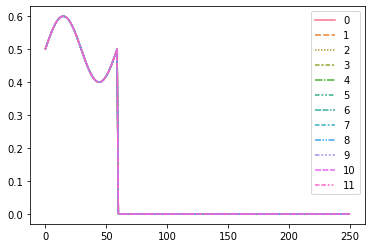

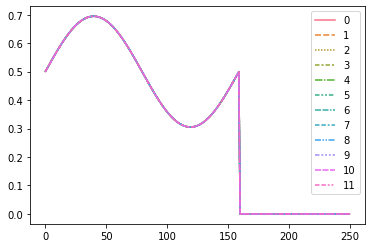

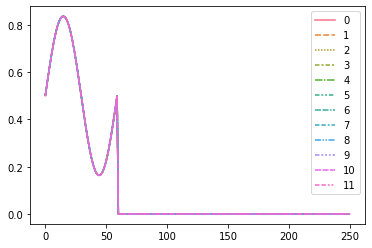

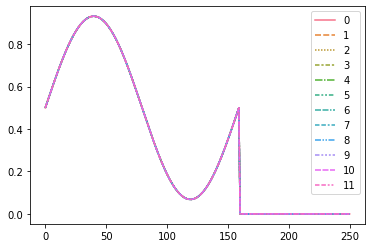

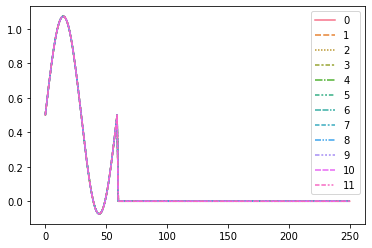

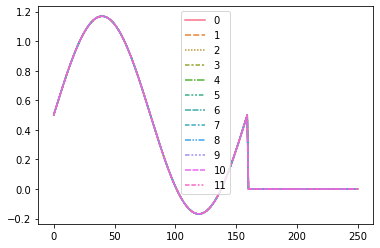

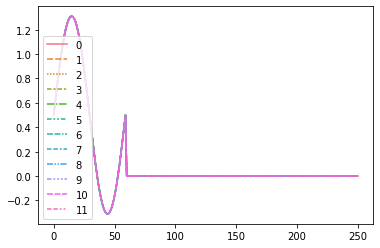

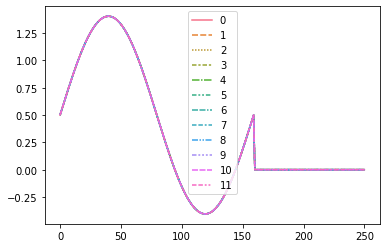

(96000, 3)
(96000, 251)


In [20]:
ARG_STEPS = 20
amplitudes = np.linspace(.1,1,ARG_STEPS)
pixel_periods = np.linspace(60,SINE_LEN,ARG_STEPS).astype(int)
phase_angles = np.linspace(0,np.pi,ARG_STEPS)

print('Expected Samples', len(amplitudes)*len(pixel_periods)*len(phase_angles))

y_list = list()
X_list = list()
for i, args in enumerate(itertools.product(amplitudes, pixel_periods, phase_angles)):
    print(i+1, end='\r')
    y_list.append(np.repeat([args], NOISE_SAMPLES, axis=0))
    amplitude, pixel_period, phase_angle = args
    X_list.append(
        np.vstack(
            [
                
                    pixel_wave(
                        pixel_period, 
                        amplitude, 
                        .5, 
                        prepend=False, 
                        n_periods=1, 
                        phase_angle=phase_angle, 
                        arr_len=SINE_LEN
                    ) 
                for _ 
                in range(NOISE_SAMPLES)
            ]
        )
    )
    if i % 1000 == 0:
        sns.lineplot(data=X_list[-1].transpose())
        plt.show()
        
y_train = np.concatenate(y_list, axis=0)
print(y_train.shape)
X_train = np.concatenate(X_list, axis=0)
print(X_train.shape)       

### Sinc Wave Generation

## Noise Generation

In [ ]:
def add_noise(arr, distribution='gaussian', symmetric=True, noise_amplitude=1, method='additive', bias=0):
    noise_len = len(arr)
    match distribution:
        case 'gaussian':
            dist = st.norm(0,1)
        case 'beta':
            dist = st.beta(0,1)
        case 'levy':
            dist = st.levy(0,1)
        case 'uniform':
            dist = st.uniform(0,1)
        case 'pareto':
            dist = st.power(0,1)
        case 't':
            dist = st.t(4,0,1)
    noise_arr = dist.rvs(size=noise_len)
    if bias:
        noise_arr = np.add(noise_arr, bias)
    if symmetric and distribution in ['beta','pareto']:
        random_indices = np.random.randint(0,1).astype(bool)
        noise_arr[random_indices] = -noise_arr[random_indices]
    if method == 'additive':
        arr = np.add(arr, noise_arr)
    elif method == 'multiplicative':
        arr = np.multiply(arr, noise_arr)
    else:
        raise ValueError(f'{method} not recognized as noise method')
    return arr

## Simple Keras Network

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Nadam
from keras.layers import LeakyReLU

# define the input 

In [ ]:
inputs = Input(shape=(SINE_LEN,))

def create_hidden(arr, neurons, alpha=.1):
    arr = Dense(neurons)(arr)
    arr = LeakyReLU(alpha=alpha)(arr)
    return arr

def create_output(arr, neurons, name):
    arr = Dense(neurons)(arr)
    arr = LeakyReLU(alpha=alpha)(arr)
    arr = Dense(1, name=name)(arr)
    return arr

hidden1 = create_hidden(inputs, 128)
hidden2 = create_hidden(hidden1, 64)
hidden3 = create_hidden(hidden2, 32)

# define the output layer
output1 = create_output(hidden3, 32, 'output1')
output2 = create_output(hidden3, 32, 'output2')

loss_weights = {'output1': 0.5, 'output2': 0.5}

model = Model(inputs=inputs, outputs=[output1, output2])
model.compile(loss='mean_squared_error', optimizer=Nadam(lr=0.002), loss_weights=loss_weights)
model.summary()

### Add Callbacks

## Duplicate PyTorch Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(SINE_LEN, 128),
            LeakyReLU(),
            nn.Linear(128, 64),
            LeakyReLU(),
            nn.Linear(64, 32),
            LeakyReLU(),
        )
        self.output = nn.Sequential(
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        output1 = self.model(x)
        output1 = self.output(output1)
        output2 = self.model(x)
        output2 = self.output(output2)
    
        return output1, output2

model = Net()
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters())
for epoch in range(N_EPOCHS):
    inputs = X
    targets = X
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch} Loss: {loss}')

## Sine Wave Side to Side

## Sine Wave Single Period